In [1]:
import numpy as np
import torch
import os
import torch.nn as nn
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
from torchvision import transforms
import random
import matplotlib.pyplot as plt

In [2]:
#type the directories which include the files downloaded from 
#https://www.kaggle.com/datasets/hasinisadunikasilva/skincancerdetectiondcnn

x_train = np.load( '..../x_train.npy')
x_test = np.load( '.../x_test.npy')
y_train = np.load( '.../y_train.npy')
y_test = np.load('.../y_test.npy')

x_train = np.transpose(x_train, (0, 3, 1, 2))#turn NHWC to NCHW format
x_test = np.transpose(x_test, (0, 3, 1, 2))#turn NHWC to NCHW format

#convert one hot to binary 
y_train = np.argmax(y_train, axis = 1)
y_test = np.argmax(y_test, axis = 1)

#convert to torch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [3]:
#data augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
    transforms.ColorJitter(
        brightness=random.uniform(0, 0.05),    # Randomly adjust brightness
        contrast=random.uniform(0, 0.05)        # Randomly adjust contrast
        #saturation=random.uniform(0, 0.1)   # Randomly adjust saturation
        #hue=random.uniform(0, 0.05)           # Randomly adjust hue
    )])

augmented_x_train = []
augmented_y_train = []

for j in range(3):
    for i in range(len(x_train)):
        image = x_train[i]
        label = y_train[i]

        augmented_image = augmentation_transforms(image)
        augmented_x_train.append(augmented_image)
        augmented_y_train.append(label)

augmented_x_train = torch.stack(augmented_x_train)
augmented_y_train = torch.tensor(augmented_y_train)

# Concatenate the original and augmented data
x_train = torch.cat((x_train, augmented_x_train))
y_train = torch.cat((y_train, augmented_y_train))

#split to train and validation datasets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

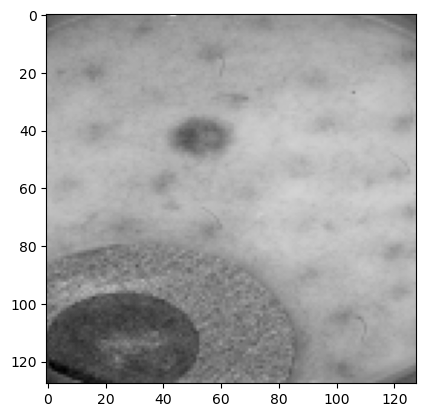

In [4]:
#We plot a random image from the dataset
img = x_train[2069]
plt.imshow(torch.permute(img, (2, 1, 0)), cmap='gray')

In [5]:
x_train.shape

torch.Size([7200, 1, 128, 128])

In [6]:
#pass the data to gpu
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

from torch.utils.data import DataLoader, TensorDataset
#create datasets
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)


batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)  
valid_dl = DataLoader(val_ds, batch_size, shuffle=False)  

class myModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)    
        self.conv3 = nn.Conv2d(in_channels=64, out_channels = 128, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=8)        
        self.flat = nn.Flatten()        
        
        #linear layers
        self.fc1 = nn.Linear(2048, 1024)
        self.relu4 = nn.ReLU()
        self.drop = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(1024, 1)
        self.a = nn.Sigmoid()
        
        # Create a module list for easy access
        l = [self.conv1, self.relu1, self.pool1, self.conv2, self.relu2, self.pool2, self.conv3, self.relu3, self.pool3,
            self.flat, self.fc1, self.relu4, self.drop, self.fc2, self.a]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

In [7]:
#create an instance of the model and move it to gpu
model = myModel().to(device)

# Define the loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 80

#below we train the model and present accuracy and loss
loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
        
        # Forward pass
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Update loss and accuracy
        loss_hist_train[epoch] += loss.item()*batch_size
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += float(is_correct.sum().item())
    
    # Compute average loss and accuracy for the epoch
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
        
    with torch.no_grad():
        for x_batch, y_batch in valid_dl:
            
            # Forward pass
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            
            # Update loss and accuracy
            loss_hist_valid[epoch] += loss.item()*batch_size
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_valid[epoch] += float(is_correct.sum().item())
    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
    if epoch%10==0:
        print(f'Epoch {epoch+1} accuracy: '
              f'{accuracy_hist_train[epoch]:.4f} val_accuracy: ' 
              f'{accuracy_hist_valid[epoch]:.4f} loss:'
              f'{loss_hist_train[epoch]:.4f} val_loss:'
              f'{loss_hist_valid[epoch]:.4f}')

Epoch 1 accuracy: 0.5387 val_accuracy: 0.6025 loss:0.6968 val_loss:0.7540
Epoch 11 accuracy: 0.8001 val_accuracy: 0.8200 loss:0.4539 val_loss:0.4597
Epoch 21 accuracy: 0.8651 val_accuracy: 0.8725 loss:0.3171 val_loss:0.3432
Epoch 31 accuracy: 0.8850 val_accuracy: 0.8950 loss:0.2704 val_loss:0.2914
Epoch 41 accuracy: 0.9094 val_accuracy: 0.9125 loss:0.2277 val_loss:0.2570
Epoch 51 accuracy: 0.9282 val_accuracy: 0.9225 loss:0.1866 val_loss:0.2430
Epoch 61 accuracy: 0.9411 val_accuracy: 0.9313 loss:0.1590 val_loss:0.1982
Epoch 71 accuracy: 0.9546 val_accuracy: 0.9313 loss:0.1257 val_loss:0.1843


In [8]:
from sklearn.metrics import classification_report

#the test dataset is small, it does not need to be passed to gpu
#below we compute precision, recall, f1-score
model.to(torch.device('cpu'))
pred = model(x_test)[:, 0]
loss = loss_fn(pred, y_test)
is_correct = ((pred>=0.5).float() == y_test).float()
accuracy = is_correct.mean()
predBin = (pred>0.5).numpy()
report = classification_report(y_test.numpy(), predBin) 

print(f'loss = {loss}, accuracy = {accuracy}')
print(report)

loss = 0.25702038407325745, accuracy = 0.8999999761581421
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        60
         1.0       1.00      0.80      0.89        60

    accuracy                           0.90       120
   macro avg       0.92      0.90      0.90       120
weighted avg       0.92      0.90      0.90       120



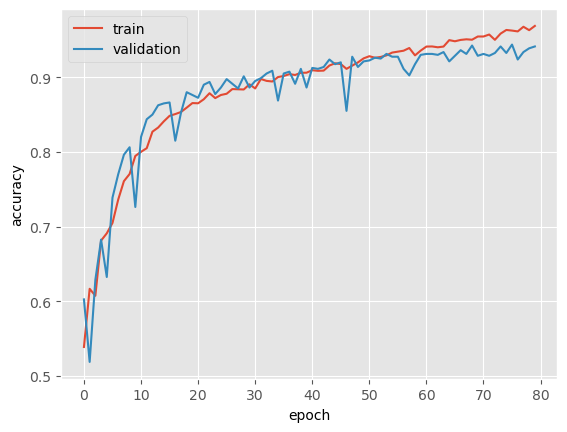

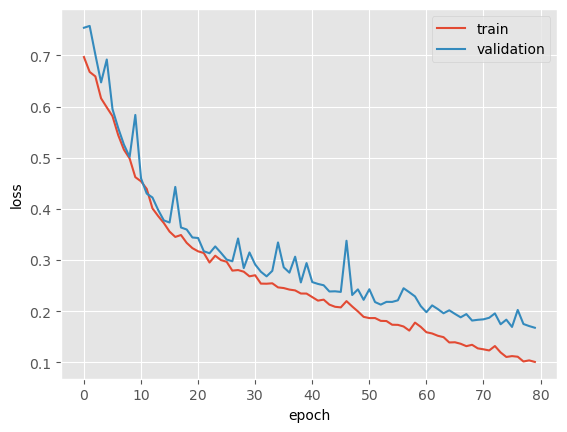

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(1)
plt.clf()
plt.plot(accuracy_hist_train, label='train')
plt.plot(accuracy_hist_valid, label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure(2)
plt.clf()
plt.plot(loss_hist_train, label = 'train')
plt.plot(loss_hist_valid, label = 'validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [10]:
#we calculate and plot the confusion matrix
from sklearn.metrics import confusion_matrix
classes = ['benign', 'malignant']
cm = confusion_matrix(y_test.numpy(), predBin)
cmNorm = cm.astype(float)/cm.sum(axis=1)[:, np.newaxis]
cmNorm

array([[1. , 0. ],
       [0.2, 0.8]])

[Text(0, 0.5, 'benign'), Text(0, 1.5, 'malignant')]

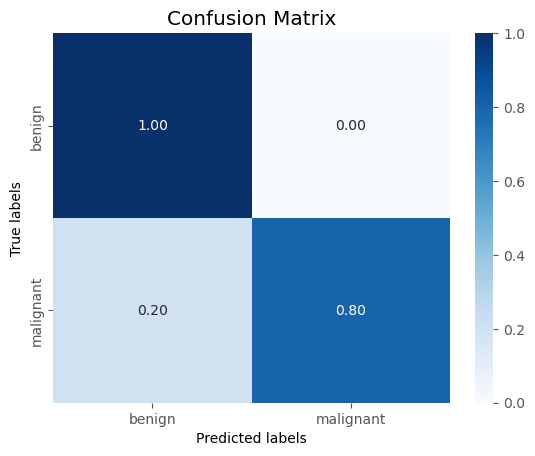

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.heatmap(cmNorm, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)


In [12]:
from sklearn.metrics import roc_auc_score

# We calculate AUC score and plot the roc curve
auc_score = roc_auc_score(y_test.numpy(), pred.detach().numpy())

print("AUC Score:", auc_score)

AUC Score: 0.9888888888888888


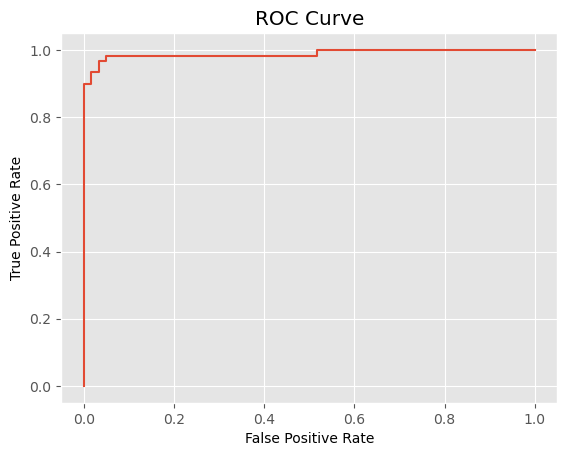

In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test.numpy(), pred.detach().numpy())

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()